In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Intern_data/

/content/drive/MyDrive/Intern_data


In [ ]:
!pip install aletheia-dnn

In [ ]:
!pip install lime

In [ ]:
!pip install shap

In [ ]:
!pip install mpld3

In [ ]:
!pip install pickle5

In [ ]:
import joblib
import pickle5 as pickle
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from aletheia import *
from lime import lime_tabular
import mpld3

# Reading Data from file

In [ ]:
#read dataset
with open('x_res.pkl', 'rb') as input:
    x_res = pickle.load(input)
    
with open('y_res.pkl', 'rb') as input:
    y_res = pickle.load(input)

In [ ]:
type(x_res)

pandas.core.frame.DataFrame

In [ ]:
x_res.shape

(49650, 26)

In [ ]:
fnames = x_res.columns.tolist()
print(fnames)

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'NAME_EDUCATION_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'LIVE_CITY_NOT_WORK_CITY_1', 'FLAG_OWN_CAR_Y', 'FLAG_DOCUMENT_8_1', 'FLAG_WORK_PHONE_1', 'REGION_RATING_CLIENT_2', 'REGION_RATING_CLIENT_3', 'NAME_CONTRACT_TYPE_Revolving loans', 'FLAG_PHONE_1', 'REG_CITY_NOT_WORK_CITY_1', 'LIVE_REGION_NOT_WORK_REGION_1', 'FLAG_EMAIL_1', 'FLAG_EMP_PHONE_1', 'FLAG_OWN_REALTY_Y', 'REG_CITY_NOT_LIVE_CITY_1']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.4,random_state=42)

#Taking some test samples out for later
X_test = X_val[10000:]
y_test = y_val[10000:]
X_val = X_val[:10000]
y_val = y_val[:10000]

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_val shape: ",X_val.shape)
print("y_val shape: ",y_val.shape)
print("X_test shape: ",X_test.shape)
print("X_test shape: ",X_test.shape)


X_train shape:  (29790, 26)
y_train shape:  (29790, 1)
X_val shape:  (10000, 26)
y_val shape:  (10000, 1)
X_test shape:  (9860, 26)
X_test shape:  (9860, 26)


In [ ]:
#Save test samples
with open('X_test.pkl', 'wb') as output:
    joblib.dump(X_test, output)
with open('y_test.pkl', 'wb') as output:
    joblib.dump(y_test, output)

# Training Inital DNN

In [ ]:
#initial unoptimized DNN 

import tensorflow as tf
from tensorflow import keras

metrics = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc')
          ]

ES = tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)
Rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)
callbacks = [ES, Rlr]

model = keras.Sequential()
model.add(keras.layers.Dense(32,activation='relu',input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
model.fit(
          x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
          callbacks=[ES, Rlr],
         )

Epoch 1/500
59/59 [==============================] - 1s 8ms/step - loss: 0.6658 - accuracy: 0.6027 - auc: 0.6402 - val_loss: 0.6260 - val_accuracy: 0.6584 - val_auc: 0.7145
Epoch 2/500
59/59 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6677 - auc: 0.7259 - val_loss: 0.5897 - val_accuracy: 0.6837 - val_auc: 0.7495
Epoch 3/500
59/59 [==============================] - 0s 3ms/step - loss: 0.5889 - accuracy: 0.6842 - auc: 0.7451 - val_loss: 0.5711 - val_accuracy: 0.7002 - val_auc: 0.7587
Epoch 4/500
59/59 [==============================] - 0s 3ms/step - loss: 0.5735 - accuracy: 0.6939 - auc: 0.7531 - val_loss: 0.5604 - val_accuracy: 0.7008 - val_auc: 0.7618
Epoch 5/500
59/59 [==============================] - 0s 3ms/step - loss: 0.5632 - accuracy: 0.6996 - auc: 0.7579 - val_loss: 0.5528 - val_accuracy: 0.7092 - val_auc: 0.7644
Epoch 6/500
59/59 [==============================] - 0s 3ms/step - loss: 0.5560 - accuracy: 0.7031 - auc: 0.7626 - val_loss: 0.5479 - v

In [ ]:
results = []
results.append(('Initial DNN',roc_auc_score(y_test,model.predict(X_test))))
print(results[-1])

('Initial DNN', 0.7803878280326728)


# Aletheia Unwrapping

In [ ]:
from aletheia import *

coefs = [layer.kernel.numpy() for layer in model.layers]
intercepts = [layer.bias.numpy() for layer in model.layers]
clf = UnwrapperClassifier(coefs, intercepts,feature_names=fnames)
clf.fit(X_train, y_train)

In [ ]:
# print(clf.summary().shape)  #dont run.crashes pc. Object too big. Need to optimize dnn

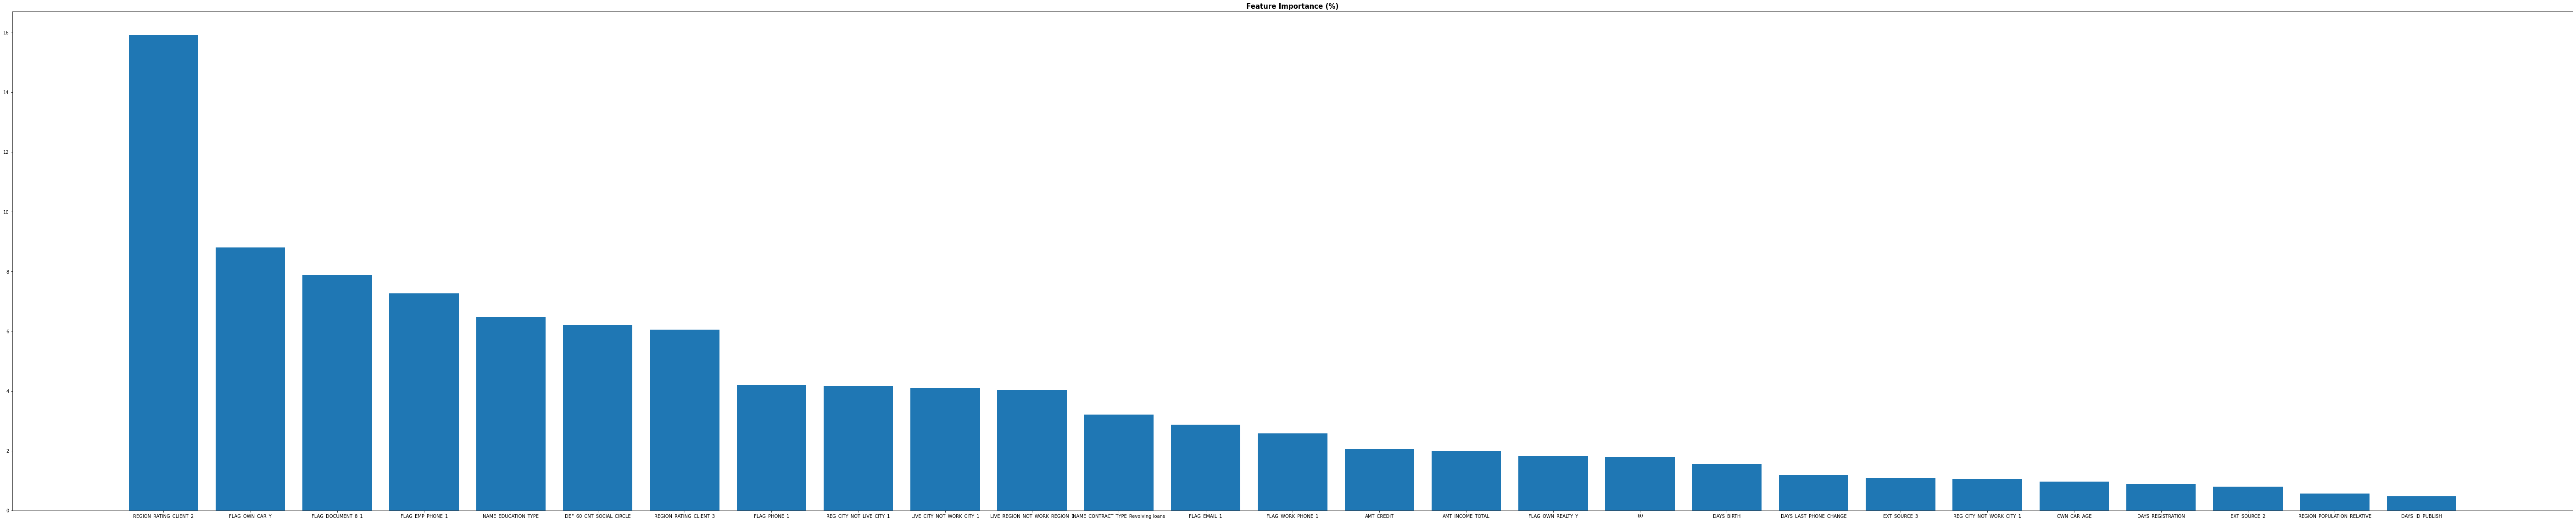

In [ ]:
#feature importance plot 
fig = clf.feature_importance_plot(figsize=(100, 20),include_b0=1)

# Merging LLMs

In [ ]:
#Using grid search to find optimal number of LLM clusters

datanum = X_train.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=0)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1

X_train_np = X_train.values
y_train_np = y_train.values

grid = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.01).astype(int),
                                     refit_model=LogisticRegression()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)
# grid = MergerClassifier(unwrapper=None,
#                       weights=coefs,
#                       biases=intercepts,
#                       min_samples=30,
#                       n_neighbors=np.round(clf1.nllms * 0.01).astype(int),
#                       refit_model=LogisticRegression(),
#                       n_clusters=10
#                      )
grid.fit(X_train_np, y_train_np)


Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1] END .................n_clusters=1; auc: (test=0.748) total time= 3.1min
[CV 1/1] END .................n_clusters=2; auc: (test=0.768) total time= 3.2min
[CV 1/1] END .................n_clusters=3; auc: (test=0.774) total time= 3.2min
[CV 1/1] END .................n_clusters=4; auc: (test=0.774) total time= 3.4min
[CV 1/1] END .................n_clusters=5; auc: (test=0.776) total time= 3.5min
[CV 1/1] END .................n_clusters=6; auc: (test=0.775) total time= 3.4min
[CV 1/1] END .................n_clusters=7; auc: (test=0.774) total time= 3.5min
[CV 1/1] END .................n_clusters=8; auc: (test=0.774) total time= 3.5min
[CV 1/1] END .................n_clusters=9; auc: (test=0.774) total time= 3.3min
[CV 1/1] END ................n_clusters=10; auc: (test=0.775) total time= 3.4min
[CV 1/1] END ................n_clusters=15; auc: (test=0.771) total time= 3.5min
[CV 1/1] END ................n_clusters=20; auc:

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  1])),
             estimator=MergerClassifier(biases=[array([ 0.05564463, -0.07092811,  0.23131742,  0.0918405 , -0.10335322,
        0.05048175, -0.00245235, -0.04160368, -0.07714047,  0.08638024,
        0.10046817,  0.00740497,  0.07705621,  0.05546864,  0.00968216,
       -0.03915994,  0.1975416 ,  0.08697756,  0.20055805,  0.24345444,
        0.03496301, -0.036...
       [-0.23368052],
       [-0.16968824],
       [-0.3584583 ],
       [-0.45079887],
       [ 0.21265517],
       [ 0.20515855],
       [ 0.8851064 ],
       [-0.61266315],
       [-0.10798008],
       [ 0.38765153],
       [ 0.7343377 ],
       [ 0.65345675],
       [-0.2068829 ],
       [-0.49876758],
       [ 0.41272715]], dtype=float32)]),
             param_grid={'n_clusters': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
             refit='auc',
             scoring={'auc': make_scorer(roc_auc_score, needs_proba=True)},
             verbose=3)

In [ ]:
#save grid file
with open('grid.pkl', 'wb') as output:
    joblib.dump(grid, output)

In [ ]:
# results on different n_cluster values
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_auc,mean_test_auc,std_test_auc,rank_test_auc
0,171.856152,0.0,16.070130,0.0,1,{'n_clusters': 1},0.748234,0.748234,0.0,12
1,178.210827,0.0,15.090551,0.0,2,{'n_clusters': 2},0.767673,0.767673,0.0,11
2,178.661271,0.0,14.956981,0.0,3,{'n_clusters': 3},0.773530,0.773530,0.0,8
3,186.636152,0.0,15.928843,0.0,4,{'n_clusters': 4},0.773668,0.773668,0.0,7
4,194.573988,0.0,15.280597,0.0,5,{'n_clusters': 5},0.775545,0.775545,0.0,1
5,189.914986,0.0,15.912681,0.0,6,{'n_clusters': 6},0.775454,0.775454,0.0,2
6,196.290391,0.0,15.326067,0.0,7,{'n_clusters': 7},0.774476,0.774476,0.0,4
7,193.254446,0.0,15.056786,0.0,8,{'n_clusters': 8},0.774347,0.774347,0.0,5
8,185.735209,0.0,14.868467,0.0,9,{'n_clusters': 9},0.774346,0.774346,0.0,6
9,190.024789,0.0,15.522214,0.0,10,{'n_clusters': 10},0.774755,0.774755,0.0,3


In [ ]:
#choose best n_cluster value
clf_merge = grid.best_estimator_

In [ ]:
#Merged DNN unwrapped
clf_merge.summary()

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,14693.0,0.324917,0.468344,0.614702,0.563184
1,5647.0,0.892686,0.309512,0.849899,0.701832
2,5628.0,0.417022,0.493067,0.613877,0.731151
3,2155.0,0.822274,0.382282,0.796636,0.698664
4,1667.0,0.571086,0.494921,0.665095,0.730853


## Getting Flattened Model with one hidden layer

In [ ]:
flatten_model = clf_merge.flatten(refit_model=LogisticRegression(C=1e10))
clf_flatten = flatten_model
clf_flatten.fit(x_res.values, y_res.values.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
results.append(('Flattened DNN', roc_auc_score(y_test,clf_flatten.predict_proba(X_test)[:,1])))
results[-1]

('Flattened DNN', 0.7860829768619458)

## Training new DNN same architecture as Flattened DNN (for comparison)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

metrics = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

ES=tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)

Rlr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)

def create_model(input_shape = (X_train.shape[1],)):
    model = keras.Sequential()
    model.add(keras.layers.Dense(5,activation='relu',input_shape=input_shape))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
    return model
              
# model = KerasClassifier(create_model, verbose=1)
model = create_model()


model.fit(x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
         callbacks=[ES, Rlr],
#           class_weight = {0: zero_weight, 1: one_weight}
         )


Epoch 1/500
59/59 [==============================] - 2s 13ms/step - loss: 0.7830 - accuracy: 0.5258 - auc: 0.5409 - prc: 0.5397 - val_loss: 0.7333 - val_accuracy: 0.5493 - val_auc: 0.5709 - val_prc: 0.5636
Epoch 2/500
59/59 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.5752 - auc: 0.6051 - prc: 0.6015 - val_loss: 0.6777 - val_accuracy: 0.6105 - val_auc: 0.6447 - val_prc: 0.6398
Epoch 3/500
59/59 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6205 - auc: 0.6609 - prc: 0.6648 - val_loss: 0.6461 - val_accuracy: 0.6465 - val_auc: 0.6924 - val_prc: 0.7005
Epoch 4/500
59/59 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.6483 - auc: 0.6940 - prc: 0.7080 - val_loss: 0.6258 - val_accuracy: 0.6688 - val_auc: 0.7195 - val_prc: 0.7383
Epoch 5/500
59/59 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6627 - auc: 0.7127 - prc: 0.7347 - val_loss: 0.6122 - val_accuracy: 0.6772 - val_auc:

In [ ]:
results.append(('Small DNN', roc_auc_score(y_test,model.predict(X_test)))) 
print(results[-1])

('Small DNN', 0.7689493302090246)


In [ ]:
print(results)

[('Initial DNN', 0.7803878280326728), ('Flattened DNN', 0.7860829768619458), ('Small DNN', 0.7689493302090246)]


In [ ]:
#saving untrained flattened model
with open("untrained_model.pkl", "wb") as output:
    joblib.dump(flatten_model, output)

with open("trained_model.pkl", "wb") as output:
    joblib.dump(clf_flatten, output)

# Interpretation of test cases

In [ ]:
def save_figure(fig, filename):
    filename = './plots/' + filename
    fig.savefig(filename, transparent=False)
    mpld3.save_html(fig, filename+".html", template_type='simple')
    mpld3.save_json(fig, filename+".json")

In [ ]:
# import lime
# from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=fnames,
    class_names=['will default', 'will repay'],
    mode='classification',
    verbose=1
)

In [ ]:
import dill as pick


In [ ]:
#save explainer
with open('explainer.pkl', 'wb') as output:
    pick.dump(explainer, output)

In [ ]:
#read explainer
with open('explainer.pkl', 'rb') as input:
  expl = pick.load(input)

In [ ]:
a = X_test.loc[X_test['AMT_CREDIT'] == 0]
len(a)

In [ ]:
exp = expl.explain_instance(
    data_row=X_test.iloc[2], 
    predict_fn=clf_flatten.predict_proba,
    # num_features=5
)

exp.show_in_notebook(show_table=True)


In [ ]:
def individual_interpretation(X_test, clf_flatten, applicationID):
  data_row = X_test.loc[X_test['Application_ID'] == applicationID]
  if len(data_row) == 0:
    return -1
  exp = explainer.explain_instance(
      data_row=data_row,
      predict_fn=clf_flatten.predict_proba
  )
  fig = exp.as_pyplot_figure()
  save_figure(fig, 'Interpretation' + str(applicatoinID))

In [ ]:
# exp.as_html()

In [ ]:
# exp.as_list()

In [ ]:
# exp.as_map()

In [ ]:
fig = exp.as_pyplot_figure()

In [ ]:
save_figure(fig, 'Interpretation')

In [ ]:
#this notebook saves 5 pickle files
# 2 files for pretrained test data
# 1 file for grid
# 1 file for trained model
# 1 file for untrained model